In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,ot.ProvinceUID,pr.Description AS province ,ot.DistrictUID ,  di.Description AS district 
, ot.AreaUID , ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO009200420,46,2018-08-18 07:59:15.147,1638,New Life Pharmacy,20.0,Western Province,22.0,Kalutara,278.0,Maggona,92,Chathura Desun,8,Kalyani Pharmacy,106,Artisol - Tablets (2x15's),1.0,1188.6,1355.00,0.0,0.0,1188.6,2018,August,8,18,7,Saturday,7
1,CSO009100366,43,2018-08-20 07:27:08.707,1650,Star Pharmacy,20.0,Western Province,22.0,Kalutara,268.0,Daragaha Town,91,Sasanga Nawod,8,Kalyani Pharmacy,38,Ciprofloxacin 5ml,3.0,59.9,68.25,0.0,0.0,179.7,2018,August,8,20,2,Monday,7
2,CSO009200439,46,2018-08-20 10:01:08.910,3398,Asian Pharmacy,20.0,Western Province,22.0,Kalutara,151.0,Kiriwaththuduwa,92,Chathura Desun,8,Kalyani Pharmacy,25,Aluminum hydroxide 240ml,80.0,216.7,247.00,0.0,0.0,17336.0,2018,August,8,20,2,Monday,10
3,CSO009200439,46,2018-08-20 10:01:08.910,3398,Asian Pharmacy,20.0,Western Province,22.0,Kalutara,151.0,Kiriwaththuduwa,92,Chathura Desun,8,Kalyani Pharmacy,25,Aluminum hydroxide 240ml,0.0,216.7,247.00,24.0,24.0,0.0,2018,August,8,20,2,Monday,10
4,CSO011800440,42,2018-08-20 15:35:26.807,3397,K.M.G Suwasewa Pharmacy 2,24.0,North Western Province,26.0,Puttalam,97.0,KULIYAPITIYA,118,,2,The West Central Pharma (Pvt) Ltd.,173,Vagibact Cream 40gm,3.0,619.0,705.60,0.0,0.0,1857.0,2018,August,8,20,2,Monday,15


In [6]:
Monthly_Sales = invoice_All.groupby("MonthName").agg({'GrossValue':'sum' , 'Month':'max'}).reset_index()
# setting Month as index column
Monthly_Sales = Monthly_Sales.set_index("Month")
Monthly_Sales.sort_index(inplace=True)
Monthly_Sales.reset_index()

,Month,MonthName,GrossValue
0,1,January,4.289872e+08
1,2,February,3.982769e+08
2,3,March,3.671017e+08
3,4,April,3.352851e+08
4,5,May,2.733966e+08
5,6,June,3.055369e+08
6,7,July,2.947796e+08
7,8,August,2.842739e+08
8,9,September,2.730479e+08
9,10,October,3.912949e+08


In [7]:
Monthly_Sales = invoice_All.groupby(["Year" , "MonthName"]).agg({'GrossValue':'sum' , 'Month':'max'}).reset_index()
# setting index column
Monthly_Sales = Monthly_Sales.set_index(["Year" , "Month"])
Monthly_Sales.sort_index(inplace=True)
Monthly_Sales = Monthly_Sales.reset_index()

Y2018 = Monthly_Sales[Monthly_Sales["Year"] == '2018']
Y2019 = Monthly_Sales[Monthly_Sales["Year"] == '2019']
Y2020 = Monthly_Sales[Monthly_Sales["Year"] == '2020']

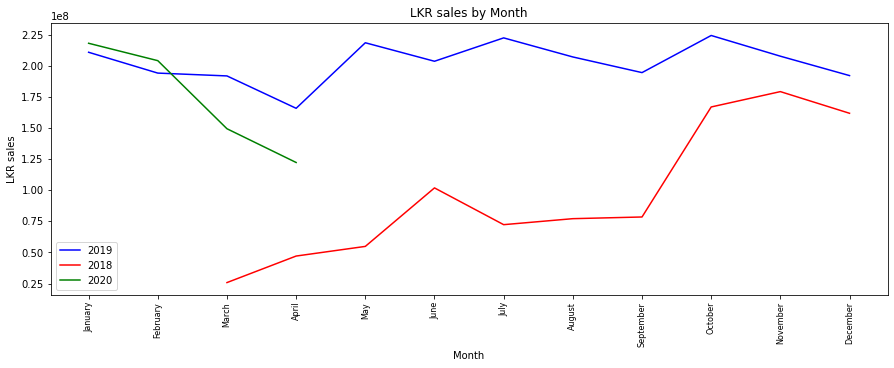

In [9]:
plt.plot(Y2019.MonthName,Y2019.GrossValue , color='blue', label='2019')
plt.plot(Y2018.MonthName,Y2018.GrossValue , color='red', label='2018')
plt.plot(Y2020.MonthName,Y2020.GrossValue , color='green', label='2020')
plt.xticks (rotation='vertical', size=8)
plt.legend()
plt.rcParams['figure.figsize'] = [15, 5]
plt.xlabel("Month")
plt.ylabel("LKR sales")
plt.title("LKR sales by Month")
plt.show()